# Notes

## Install and Import

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

### preprocessing text data

In [5]:
data={"label":[], "sentence":[]}
with open('train_10k.txt','r') as text:
  for l in text:
    check=l.split()
    data["label"].append(check[0][9:])

    sent=""
    for i in check[1:]:
      sent+=i+" "
    data["sentence"].append(sent)

data

{'label': ['Hindi',
  'Malayalam',
  'Sindhi',
  'Telugu',
  'Konkani',
  'Punjabi',
  'Maithili',
  'Kashmiri',
  'Sanskrit',
  'Assamese',
  'Telugu',
  'Gujarati',
  'Bodo',
  'Sindhi',
  'Sanskrit',
  'Punjabi',
  'Kannada',
  'Malayalam',
  'Kannada',
  'English',
  'Other',
  'Bangla',
  'Urdu',
  'Gujarati',
  'Kannada',
  'Assamese',
  'Sindhi',
  'Bodo',
  'Bangla',
  'English',
  'Konkani',
  'Sanskrit',
  'Sindhi',
  'Other',
  'Tamil',
  'English',
  'Sanskrit',
  'Manipuri_Mei',
  'Bangla',
  'Marathi',
  'English',
  'Bangla',
  'Kashmiri',
  'Telugu',
  'Bangla',
  'Manipuri_Mei',
  'Marathi',
  'Konkani',
  'Bangla',
  'Gujarati',
  'Tamil',
  'Marathi',
  'Malayalam',
  'Bangla',
  'Tamil',
  'Sindhi',
  'Punjabi',
  'Malayalam',
  'English',
  'Gujarati',
  'Punjabi',
  'Bodo',
  'Urdu',
  'Bodo',
  'Bangla',
  'Bangla',
  'English',
  'Kannada',
  'Malayalam',
  'Sindhi',
  'Malayalam',
  'Bangla',
  'Bodo',
  'Hindi',
  'Sindhi',
  'Malayalam',
  'Other',
  'Urdu',


In [6]:
df=pd.DataFrame(data)

In [7]:
df.head()

,label,sentence
0,Hindi,aisee bachat hamein una sthitiyon mein bhee sa...
1,Malayalam,kramanugathamaayi eee alavu kootti 15 varsham ...
2,Sindhi,mislan : musjid nabvi jee qareeb hikk board te...
3,Telugu,haikortu nambaru prakaram :
4,Konkani,samajik samatayechyo baryoch ghoshana karoon l...


In [8]:
df.shape

(10000, 2)

In [9]:
df.sample(10)

,label,sentence
265,Bodo,be rajkanti dwlwni swmwndwi bwhwiti danni 31 k...
5256,Konkani,jaivant sardesai
3983,Tamil,idhu thavirntha aenaiya abiviruththi seyarpaad...
2916,Konkani,hem rojaar tey shetkaar aangavonechyo chuttam ...
5599,Sanskrit,mahaarouravaraajashcha sthaanam teshaam nibodh...
7034,Oriya,ehipari shukra taralyaru dhwajabhangabhali bha...
1525,Sanskrit,bahadurakhan poorvam burhanpuradurgasya prabha...
1457,Marathi,yaa cinematil aanakhi eka vyaktirekha samore a...
795,Hindi,"baad mein , iss avadharana koo jameen millie a..."
1743,Punjabi,tii dee vaccine 2 bimariaan toon bachaa karda ...


In [10]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values
sentences[:10]

['[CLS] aisee bachat hamein una sthitiyon mein bhee sahaayata karati haye , jaba humm kamai karane mein saksham naheen hotey hain , udaaharan key liye sevaanivritti key baad .  [SEP]',
 '[CLS] kramanugathamaayi eee alavu kootti 15 varsham ( praayapoortthi ) aakumbol oro maratthinum 50 kiloo pachila / compoost / jaiva valangalil eathenkilum onnum 500:250:100 gram kanakkil raasavalavum nalkanam .  [SEP]',
 '[CLS] mislan : musjid nabvi jee qareeb hikk board tee likhyal dithham :  [SEP]',
 '[CLS] haikortu nambaru prakaram :  [SEP]',
 '[CLS] samajik samatayechyo baryoch ghoshana karoon legeet hyaa deshant nigro khaatir jaay tashe hakk hanga naat .  [SEP]',
 "[CLS] jailh jaanh vaale jatthe noon ravana kardiaan sree panoon neey kiha kii \\ ' jailh bharo \\ ' andolan lagatar jaari rahega atey aaunde kujh dinan takk bibiaan dey jatthe vee jailh bharo andolan witch shamal qarr ditte jaange .  [SEP]",
 '[CLS] geet merae khaga baal !  [SEP]',
 "[CLS] R I hom ' sund hemak sund hom ' sɨnd ' hemak se

## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [11]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'ai', '##see', 'bach', '##at', 'ham', '##ein', 'una', 'st', '##hiti', '##yon', 'mein', 'b', '##hee', 'sa', '##ha', '##aya', '##ta', 'kara', '##ti', 'hay', '##e', ',', 'ja', '##ba', 'hum', '##m', 'kam', '##ai', 'kara', '##ne', 'mein', 'sa', '##ksha', '##m', 'nah', '##een', 'hot', '##ey', 'hai', '##n', ',', 'ud', '##aa', '##hara', '##n', 'key', 'li', '##ye', 'se', '##va', '##ani', '##vr', '##itt', '##i', 'key', 'ba', '##ad', '.', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length.

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length.

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [13]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [14]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [15]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [16]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [17]:
len(input_ids)

10000

Create the attention masks

In [18]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [19]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [20]:
print("training labels",np.unique(train_labels))
np.unique(validation_labels)

training labels ['Assamese' 'Bangla' 'Bodo' 'English' 'Gujarati' 'Hindi' 'Kannada'
 'Kashmiri' 'Konkani' 'Maithili' 'Malayalam' 'Manipuri_Mei' 'Marathi'
 'Nepali' 'Oriya' 'Other' 'Punjabi' 'Sanskrit' 'Sindhi' 'Tamil' 'Telugu'
 'Urdu']


array(['Assamese', 'Bangla', 'Bodo', 'English', 'Gujarati', 'Hindi',
       'Kannada', 'Kashmiri', 'Konkani', 'Maithili', 'Malayalam',
       'Manipuri_Mei', 'Marathi', 'Nepali', 'Oriya', 'Other', 'Punjabi',
       'Sanskrit', 'Sindhi', 'Tamil', 'Telugu', 'Urdu'], dtype=object)

In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
validation_labels = label_encoder.transform(validation_labels)

In [22]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Train Model

Now that our input data is properly formatted, it's time to fine tune the BERT model.

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

We'll load [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.

<img src='https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcR-hV5tsDFdanx37pw9jzx3_Br30T2RnwsEJUhcsT-R_ugjdh3YVJuJNe1_e2l8nhYpVO9O'>

### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.  

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [24]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=22)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [26]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [27]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [28]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.2786281339122814


Epoch:  25%|██▌       | 1/4 [04:18<12:54, 258.23s/it]

Validation Accuracy: 0.8174603174603174
Train loss: 0.3605839352670984


Epoch:  50%|█████     | 2/4 [08:38<08:38, 259.33s/it]

Validation Accuracy: 0.8849206349206349
Train loss: 0.13931039823665817


Epoch:  75%|███████▌  | 3/4 [12:51<04:16, 256.48s/it]

Validation Accuracy: 0.8918650793650794
Train loss: 0.06063668179568929


Epoch: 100%|██████████| 4/4 [17:04<00:00, 256.03s/it]

Validation Accuracy: 0.8918650793650794


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!kill -9 -1


In [25]:
!nvidia-smi



Thu Aug 14 14:29:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             29W /   70W |     574MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Training Evaluation

Let's take a look at our training loss over all batches:

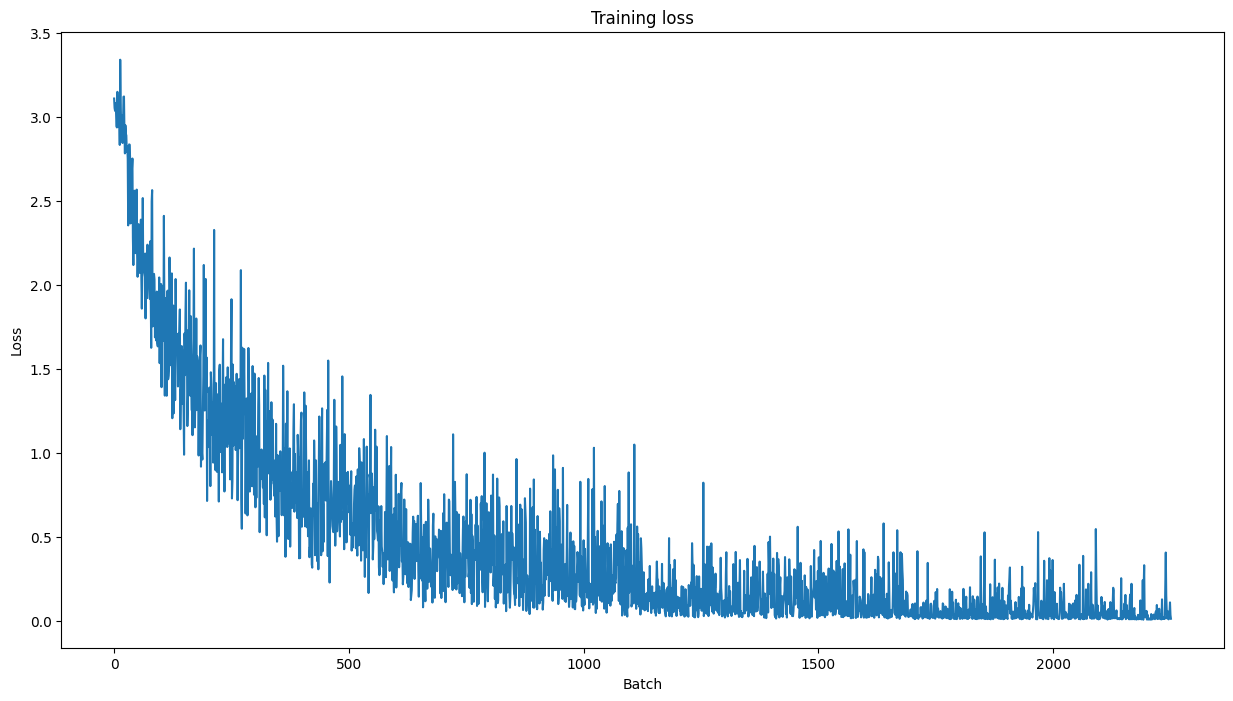

In [31]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [32]:
#using the same code using to preprocess the val data from evaluation
data_val={"label":[], "sentence":[]}
with open('val_1k.txt','r') as text:
  for l in text:
    check=l.split()
    data_val["label"].append(check[0][9:])

    sent=""
    for i in check[1:]:
      sent+=i+" "
    data_val["sentence"].append(sent)

data_val

{'label': ['Kashmiri',
  'Assamese',
  'Oriya',
  'Sanskrit',
  'Punjabi',
  'Kannada',
  'Bangla',
  'Other',
  'Maithili',
  'Hindi',
  'Other',
  'Telugu',
  'Gujarati',
  'Telugu',
  'Malayalam',
  'Nepali',
  'Nepali',
  'Malayalam',
  'Tamil',
  'Sindhi',
  'Marathi',
  'Manipuri_Mei',
  'Manipuri_Mei',
  'Punjabi',
  'Assamese',
  'Sanskrit',
  'Urdu',
  'English',
  'English',
  'Telugu',
  'Bangla',
  'Punjabi',
  'Marathi',
  'Tamil',
  'Hindi',
  'Telugu',
  'Kannada',
  'Gujarati',
  'Gujarati',
  'Oriya',
  'Other',
  'Assamese',
  'Sindhi',
  'Maithili',
  'Telugu',
  'Assamese',
  'Maithili',
  'Other',
  'Hindi',
  'Nepali',
  'Punjabi',
  'Kannada',
  'Nepali',
  'Manipuri_Mei',
  'Gujarati',
  'Telugu',
  'Punjabi',
  'Assamese',
  'Oriya',
  'Sindhi',
  'Kannada',
  'Nepali',
  'Tamil',
  'Assamese',
  'Telugu',
  'Kashmiri',
  'Marathi',
  'Gujarati',
  'Gujarati',
  'Punjabi',
  'Sanskrit',
  'Punjabi',
  'Kannada',
  'Sindhi',
  'Urdu',
  'Telugu',
  'Marathi',
  

In [36]:
df = pd.DataFrame(data_val)

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

prediction_labels = torch.tensor(labels)

batch_size = 16


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [37]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [38]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [39]:
matthews_set

[np.float64(0.7446875933994077),
 np.float64(0.6667228946148682),
 np.float64(0.9347826086956522),
 np.float64(0.8078679646823672),
 np.float64(0.8690039187664382),
 np.float64(0.8661059519775998),
 np.float64(0.688702486224654),
 np.float64(0.935931622058421),
 np.float64(0.6724954949247813),
 np.float64(0.7347826086956522),
 np.float64(0.9342105263157895),
 np.float64(0.8053412701479471),
 np.float64(0.8035011108192193),
 np.float64(0.735689958019051),
 np.float64(0.8008849557522124),
 np.float64(0.8050847457627118),
 np.float64(0.9347826086956522),
 np.float64(0.7403221751892368),
 np.float64(0.8111662691337524),
 np.float64(0.9353448275862069),
 np.float64(0.7343534474570096),
 np.float64(0.8695980950674562),
 np.float64(0.8695652173913043),
 np.float64(0.8739460855427935),
 np.float64(0.8035011108192193),
 np.float64(0.8077218108175414),
 np.float64(0.8679172077468597),
 np.float64(0.7489247664799692),
 np.float64(0.8678498307170841),
 np.float64(0.8052627168725032),
 np.float64(1

In [40]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [41]:
matthews_corrcoef(flat_true_labels, flat_predictions)

np.float64(0.7983983783135264)

Cool! In about half an hour and without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score. I should also mention we didn't train on the entire training dataset, but set aside a portion of it as our validation set for legibililty of code.

If you look at the leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy), you'll see that our score (54) using the small version of BERT actually slightly outperforms the BERT authors' CoLA score (52) with the same model. If you wanted to tune the hyperparameters, use the entire train set, or use the larger BERT model instead you're likely able to push that score up higher into the mid- 60s, which looks like the state of the art as of July 2019!


## Conclusion

This post demonstrate that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.